In [28]:
'''Loading libraries'''
import pandas as pd 
import numpy as np 
from scipy.stats import dirichlet, beta, nbinom, norm
from scipy.special import loggamma,gamma
import time
import matplotlib.pyplot as plt
import math

'''
Notes: 
- https://stackoverflow.com/questions/9559346/deal-with-overflow-in-exp-using-numpy
- Fix the saving files part, memory problms 
- Track running time
- create a function to save files/images with a labeled name 
'''


'''Important parameters I need to constantly change'''
k = 100

sim = 500
start_time = time.time()


ModuleNotFoundError: No module named 'bigfloat'

In [2]:
'''Loading dataset'''
filename = "C:\\Users\\raoki\\Documents\\GitHub\\project_spring2019\\Data\\data_final_log.csv"
#filename = "C:\\Users\\raque\\Google Drive\\SFU\\Project 2 - Spring 2019\\Data\\data_final.csv"
#filename = "C:\\Users\\raque\\Google Drive\\SFU\\Project 2 - Spring 2019\\Data\\data_final_sub.csv"
data = pd.read_csv(filename, sep=',')


In [31]:
'''Saving time in the first part'''

#data = data.iloc[:, 0:10000]
#data = data.sample(n=).reset_index(drop=True)
from sklearn.model_selection import train_test_split

data, test = train_test_split(data, test_size=0.3, random_state=42)
print(data.shape, test.shape)


(1997, 20548) (1997, 20548) (857, 20548)


In [4]:
'''Organizing columns names'''
lr = data.columns[[2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
y = data.columns[3]
remove = data.columns[[0,1]]
#data_complete = data.copy()
#for i in np.arange(19,data.shape[1]):
#    data.iloc[:,i] = np.log(data.iloc[:,i]+1)

In [5]:
print(lr,y,remove)

Index(['gender', 'abr_ACC', 'abr_BLCA', 'abr_CHOL', 'abr_ESCA', 'abr_HNSC',
       'abr_LGG', 'abr_LIHC', 'abr_LUSC', 'abr_MESO', 'abr_PAAD', 'abr_PRAD',
       'abr_SARC', 'abr_SKCM', 'abr_TGCT', 'abr_UCS'],
      dtype='object') y Index(['X', 'patients'], dtype='object')


In [6]:
'''
Class to work with model parameters
I thought about using the default values as chain starting values, 
however, i encouter problems to change the size of arrays and matrices 
according with my currently k
'''
class parameters:
    def __init__(self, latent_v,latent_cj,latent_sk,latent_ev,latent_phi ,latent_tht, prediction):
        self.ln = latent_v #array with parameters that are only one number [0-c0,1-gamma0]
        self.la_cj = latent_cj #aaray J
        self.la_sk = latent_sk #array K
        self.la_ev = latent_ev #array V
        self.lm_phi = latent_phi #matrix (jk)
        self.lm_tht = latent_tht #matrix  (kv)      
        self.p = prediction #array [intercept, gender, 15 cancer types, k genes]


In [7]:
'''
Proposal distribution
NEED TO UPDATE

'''

#Proposal values for the parameters related to the factor model 
#Repete the parameters related to prediction and only propose
#new values for the factor analysys part
#output is the parameters class 
def proposal_f(current):
    new = parameters(np.random.normal(current.ln,0.05), 
                     np.random.normal(current.la_cj,0.01),
                     np.random.normal(current.la_sk,0.005),
                     np.random.normal(current.la_ev,0.005),
                     np.random.normal(current.lm_phi,0.0000005), #remmeber that lm_phi sum up 1 in the line (genes)
                     np.random.normal(current.lm_tht,0.005), #remember the average value is 7.42
                     current.p)
    #phi and tht can't be negative 
    new.lm_phi[new.lm_phi<0] = 0.0000001 #this number needs to be smaller 
    col_sums = new.lm_phi.sum(axis=0)
    new.lm_phi = new.lm_phi / col_sums[np.newaxis,:]
    new.lm_tht[new.lm_tht<0]=0
    new.lm_tht = new.lm_tht+0.000001
    
    return new

#Proposal values for the parameters related to logistic regression 
#Repete the parameters related to factor analysis part and propose
#new values for the logistc regression parameters 
#output is the parameters class 
def proposal_p(current):
    new = parameters(current.ln,current.la_cj ,current.la_sk, #current.la_pj, 
                     current.la_ev, current.lm_phi, current.lm_tht, 
                     np.random.normal(current.p,0.05))
    return new

In [8]:
'''Ratio functions'''
def ration_f(p_new,p_cur, data_F,k):
    '''Priori Ration'''
    #log(1680)=7.42
    #J is samples and V is genes
    j = data_F.shape[0]
    v = data_F.shape[1]
    #A: phi_jk~Dir(eta_j)
    #print(loggamma(np.exp(np.sum(np.log(p_cur.la_ev)))),
    #       loggamma(np.exp(np.sum(np.log(p_new.la_ev)))))
    A0 = k*(loggamma(np.exp(np.sum(np.log(p_cur.la_ev))))-
           loggamma(np.exp(np.sum(np.log(p_new.la_ev)))))
    A1 = k*(np.sum(np.log(gamma(p_new.la_ev)))-np.sum(np.log(gamma(p_cur.la_ev))))
    A2 = np.matmul((p_new.la_ev-1),np.log(p_new.lm_phi)).sum()-np.matmul((p_cur.la_ev-1),np.log(p_cur.lm_phi)).sum()
    #print('A', p_cur.la_ev[0:5],np.log(p_cur.la_ev)[0:5],np.sum(np.log(p_cur.la_ev)))
    #B: eta_j~Gamma(a0,b0)
    a0 = 1#/(2*v)
    b0 = 1#/(2*v)
    B = (a0-1)*(np.log(p_new.la_ev)-np.log(p_cur.la_ev)).sum()+(p_cur.la_ev-p_new.la_ev).sum()/b0
    
    #C: theta_kl~Gamma(sk,cj)
    C0 = j*(loggamma(p_cur.la_sk).sum()-loggamma(p_new.la_sk).sum())+(
    p_cur.la_sk.sum()*np.log(p_cur.la_cj).sum()-p_new.la_sk.sum()*np.log(p_new.la_cj).sum())
    '''
    print('c1',np.matmul(p_new.la_sk-1,np.log(p_new.lm_tht).sum(axis=1)),
          np.matmul(p_cur.la_sk-1,np.log(p_cur.lm_tht).sum(axis=1)))
    if math.isnan(np.matmul(p_new.la_sk-1,np.log(p_new.lm_tht).sum(axis=1))):
        print('print something')
        for i in np.arange(0,len(np.log(p_new.lm_tht).sum(axis=1))):
            if math.isnan(np.log(p_new.lm_tht).sum(axis=1)[i]):
                print('almost there')
                for j in np.arange(0,len(np.log(p_new.lm_tht))):
                    print(j,np.log(p_new.lm_tht[i,j]))
                    if math.isnan(np.log(p_new.lm_tht[i,j])):
                        print('\n','value',p_new.lm_tht[i,j],'\n')
    '''            
    C1 = np.matmul(p_new.la_sk-1,np.log(p_new.lm_tht).sum(axis=1))-np.matmul(
        p_cur.la_sk-1,np.log(p_cur.lm_tht).sum(axis=1))
    C2 = np.divide(p_cur.lm_tht.sum(axis=0),p_cur.la_cj).sum()-np.divide(p_new.lm_tht.sum(axis=0),p_new.la_cj).sum()
    
    #D: sk~Gamma(gamma0,c0), gamma0 = c0 = (v*averageExpression)^0.5
    average4 = np.sqrt(np.sqrt(v*7.42))
    gamma0 = average4
    c0 = average4
    D = (gamma0-1)*(np.log(p_new.la_sk)-np.log(p_cur.la_sk)).sum()+(p_cur.la_sk-p_new.la_sk).sum()/c0
    
    #E: Cj~Gamma(a1,b1)
    a1 = average4
    b1 = average4
    E = (a1-1)*(np.log(p_new.la_cj)-np.log(p_cur.la_cj)).sum()+(p_cur.la_cj-p_new.la_cj).sum()/b1
    
    #F: gamma0~Gamma(a2,b2)
    average8 = np.sqrt(average4)
    a2 = average8
    b2 = average8
    F = (a2-1)*(np.log(p_new.ln[1])-np.log(p_cur.ln[1]))+(p_cur.ln[1]-p_new.ln[1])/b2
    
    #G: c0~Gamma(a3,b3)
    a3 = average8
    b3 = average8
    G = (a3-1)*(np.log(p_new.ln[0])-np.log(p_cur.ln[0]))+(p_cur.ln[0]-p_new.ln[0])/b3
    '''Likelihood'''
    #I: n_vj~Poisson(phi_vk theta_kj)
    I0 = np.transpose(np.log(np.matmul(p_new.lm_phi,p_new.lm_tht))-np.log(np.matmul(p_cur.lm_phi,p_cur.lm_tht)))
    #print(I0.shape,I0[0:5],data_F.head())
    I1 = np.multiply(data_F.to_numpy(),I0).sum() #as_matrix()
    I2 = (np.matmul(p_cur.lm_phi,p_cur.lm_tht)-np.matmul(p_new.lm_phi,p_new.lm_tht)).sum()
    #print('ratio - F',"%0.2f" % A0,"%0.2f" % A1,"%0.2f" % A2,"%0.2f" % B,"%0.2f" % C0,
    #      "%0.2f" % C1,"%0.2f" % C2,"%0.2f" % D,"%0.2f" % E, "%0.2f" % F,"%0.2f" % G,
    #     "%0.2f" % I1,"%0.2f" % I2,'end',(A0+A1+A2+B+C0+C1+C2+D+E+F+G+I1+I2))
    return (A0+A1+A2+B+C0+C1+C2+D+E+F+G+I1+I2)

In [9]:
def ratio_p(p_new,p_cur, data_P,k,y):
    sigma0 = 5
    sigma = 5
    mu0 = -len(p_new.p)
    mu = 1
    #H: beta~normal(mu,sigma2)
    H0 = (1/(sigma0*sigma0))*((p_cur.p[0]-mu0)*(p_cur.p[0]-mu0)-(p_new.p[0]-mu0)*(p_new.p[0]-mu0))*0.5
    H1 = (np.multiply((p_cur.p-mu),(p_cur.p-mu))-np.multiply((p_new.p-mu),(p_new.p-mu))).sum()
    H1 = H1 - (p_cur.p[0]-mu)*(p_cur.p[0]-mu)+(p_new.p[0]-mu)*(p_new.p[0]-mu)
    H1 = (H1*(len(p_new.p)-1)/sigma)*0.5
    
    #J: y~Log(xbeta)
    data_P = data_P.to_numpy()#as_matrix()
    #print('dataP inside ratio',data_P[0:5])
    #data_P = np.append(np.array(np.repeat(1,data_P.shape[0])), data_P, axis=1)
    data_P = np.hstack((np.array(np.repeat(1,data_P.shape[0])).reshape(data_P.shape[0],1),data_P))
    data_P = np.hstack((data_P,np.transpose(p_cur.lm_tht)))
    #print('\n lm_tht',np.transpose(p_cur.lm_tht))
    xw_new = np.dot(data_P,p_new.p)
    xw_cur = np.dot(data_P,p_cur.p)
    J = (-np.log(1+np.exp(xw_new))+
          np.dot(y,xw_new)).sum()/((-np.log(1+np.exp(xw_cur))+
                                                        np.dot(y,xw_cur))).sum()
    #print('ratio - P',"%0.2f" % H0,"%0.2f" % H1,"%0.2f" % J, (H0+H1+J) )
    return (H0+H1+J)

In [10]:
'''
Creatint the MCMC for the model
MCMC(
startvalue = initial value for the parameters
iterations = 
data = complete data with all columns 
k = number of latent variables
remove, lr, y = columns names to be removed, presente only in the logistic regression part and y
)
'''
def MCMC(startvalue, iterations, data,k, lr,y):
    #print('all',data.head())
    '''Splitting dataset'''
    data_P = data[lr]
    #print('\n P',data_P.head())
    data_F = data.drop(lr,axis = 1)
    data_F = data_F.drop(y,axis = 1)
    y = data[y]
    a_P = 0
    a_F = 0
    '''
    Initialization of the chains
    Note: chain_f has elements from chain_p and vice-versa. Take care to not use incorrectly
    '''     
    chain_f = []
    chain_p = []
    chain_f.append(startvalue)
    chain_p.append(startvalue)
     
    for i in np.arange(1,iterations):
        '''Factor Analysis - Latent Features'''
        #use chain_f or chain_p don't make difference here because
        #the only parameters changed are the logistic regression and 
        #they aren't used in the factor analysis part. 
        param_new_f = proposal_f(chain_f[i-1])
        param_cur_f = chain_f[i-1] 
        if i%10 == 0: 
            a = a_F*100/i
            b = a_P*100/i
            print('iteration ',i,' acceptance ', "%0.2f" % a,'-', "%0.2f" % b)
        #prob_f = np.exp(posterior(param_new_f,data_F,data_P,y,k)-posterior(param_cur_f,data_F,data_P,y,k))
        prob_f = np.exp(ration_f(param_new_f,param_cur_f, data_F,k))
        if np.random.uniform(0,1,1)<prob_f:
            chain_f.append(param_new_f)
            a_F+=1
        else:
            chain_f.append(param_cur_f) 
        '''Logistic Regression - Prediction'''
        #chain_f[i] has the most update latent parameters and haven't changed the 
        #prediction parameters from [i-1] iteration
        param_new_p = proposal_p(chain_f[i-1])
        param_cur_p = chain_f[i-1]
        #print(param_new_p.p[0:20],param_cur_p.p[0:20])
        prob_p = np.exp(ratio_p(param_new_p,param_cur_p,data_P,k,y))
        #print('F: ',prob_f, 'P: ',prob_p,'\n')
        if np.random.uniform(0,1,1)<prob_p:
            chain_p.append(param_new_p)
            a_P+=1
        else:
            chain_p.append(param_cur_p)     

    return chain_p, chain_f, a_P, a_F
        
        

In [11]:
'''Non informative prioris: dirichlet has only 1, gamma distribution with 1 average, etc'''
#UPDATE NUMBERS ACCORDING WITH POISSON AND LOG(N)
aux = len(lr)+1
data = data.drop(remove,axis = 1)
v = (data.shape[1]-aux)
j = data.shape[0]
start = parameters([1.65,1.65], #ln [0-c0,1-gamma0]
                   np.repeat(2.72,j), #la_cj
                   np.repeat(2.72,k), #la_sk
                   np.repeat(1,v), #la_ev
                   np.repeat(1/(data.shape[1]-aux),(data.shape[1]-aux)*k).reshape((data.shape[1]-aux),k),#lm_phi v x k 
                   np.repeat(7.42,(data.shape[0])*k).reshape(k,(data.shape[0])), #lm_theta k x j
                   np.concatenate(([-(k*7.42)], np.repeat(1,k+aux-1))))  #p, k+aux-1  because intercept is already counted



In [12]:
#data = data.drop(remove,axis=1)
start_time = time.time()
output_p, output_f, acept_P,acept_F = MCMC(start,sim,data,k,lr,y)
end_time = time.time() - start_time
np.set_printoptions(threshold=50)

print("--- %s seconds ---" % (time.time() - start_time))



C:\Users\raoki\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\raoki\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\raoki\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp


iteration  10  acceptance  50.00 - 40.00
iteration  20  acceptance  40.00 - 35.00
iteration  30  acceptance  43.33 - 46.67
iteration  40  acceptance  47.50 - 45.00
iteration  50  acceptance  44.00 - 48.00
iteration  60  acceptance  45.00 - 50.00
iteration  70  acceptance  42.86 - 51.43
iteration  80  acceptance  42.50 - 52.50
iteration  90  acceptance  41.11 - 51.11
iteration  100  acceptance  43.00 - 47.00
iteration  110  acceptance  42.73 - 44.55
iteration  120  acceptance  42.50 - 42.50
iteration  130  acceptance  42.31 - 43.85
iteration  140  acceptance  40.00 - 43.57
iteration  150  acceptance  42.00 - 45.33
iteration  160  acceptance  41.88 - 43.12
iteration  170  acceptance  41.18 - 42.94
iteration  180  acceptance  40.00 - 41.11
iteration  190  acceptance  41.58 - 40.00
iteration  200  acceptance  42.00 - 40.00
iteration  210  acceptance  41.90 - 39.52
iteration  220  acceptance  42.27 - 40.45
iteration  230  acceptance  43.04 - 40.43
iteration  240  acceptance  42.08 - 39.58
i

In [24]:
'''Organizing outputs'''

#TRANSFORM IN A FUNCTION TO STOP HAVE MEMORY PROBLEMS 

#Logistic Regression Parameters 
output_logistic = np.concatenate((output_p[0].p,output_p[1].p),axis = 0)
#Factor Model parameters
output_factor_ln = np.concatenate((output_f[0].ln,output_f[1].ln),axis = 0)
output_factor_la_sk = np.concatenate((output_f[0].la_sk,output_f[1].la_sk),axis = 0)
#Matrix AxB is saved as a line A*B elements 
output_factor_lm_phi= np.concatenate((output_f[0].lm_phi,output_f[1].lm_phi),axis = 0)
output_factor_lm_tht= np.concatenate((output_f[0].lm_tht,output_f[1].lm_tht),axis = 0)


for i in np.arange(2,sim):
    output_logistic = np.concatenate((output_logistic,output_p[i].p),axis = 0)
    output_factor_ln = np.concatenate((output_factor_ln,output_f[i].ln),axis = 0)
    output_factor_la_sk = np.concatenate((output_factor_la_sk,output_f[i].la_sk),axis = 0)

output_logistic = output_logistic.reshape(sim,len(output_p[0].p) )    
output_factor_ln = output_factor_ln.reshape(sim,len(output_f[0].ln) )
output_factor_la_sk = output_factor_la_sk.reshape(sim,len(output_f[0].la_sk) )   

np.savetxt('Data\\output_logistic.txt', output_logistic, delimiter=',')  
np.savetxt('Data\\output_factor_ln.txt', output_factor_ln, delimiter=',')  
np.savetxt('Data\\output_factor_la_sk.txt', output_factor_la_sk, delimiter=',')  

'''
    output_factor_lm_phi = np.concatenate((output_factor_lm_phi,output_f[1].lm_phi),axis = 0)
    output_factor_lm_tht = np.concatenate((output_factor_lm_tht,output_f[1].lm_tht),axis = 0)
    
output_factor_lm_phi = output_factor_lm_phi.reshape(sim,output_f[0].lm_phi.shape[0]*output_f[0].lm_phi.shape[1])   
output_factor_lm_tht = output_factor_lm_tht.reshape(sim,output_f[0].lm_tht.shape[0]*output_f[0].lm_tht.shape[1])

np.savetxt('Data\\output_factor_lm_phi.txt', output_factor_lm_phi, delimiter=',')  
np.savetxt('Data\\output_factor_lm_tht.txt', output_factor_lm_tht, delimiter=',')  
'''

"\n    output_factor_lm_phi = np.concatenate((output_factor_lm_phi,output_f[1].lm_phi),axis = 0)\n    output_factor_lm_tht = np.concatenate((output_factor_lm_tht,output_f[1].lm_tht),axis = 0)\n    \noutput_factor_lm_phi = output_factor_lm_phi.reshape(sim,output_f[0].lm_phi.shape[0]*output_f[0].lm_phi.shape[1])   \noutput_factor_lm_tht = output_factor_lm_tht.reshape(sim,output_f[0].lm_tht.shape[0]*output_f[0].lm_tht.shape[1])\n\nnp.savetxt('Data\\output_factor_lm_phi.txt', output_factor_lm_phi, delimiter=',')  \nnp.savetxt('Data\\output_factor_lm_tht.txt', output_factor_lm_tht, delimiter=',')  \n"

In [14]:
#acceptance and rejection  problem 
#create a easy way to identify paramerters based on name
#test several parameters at once

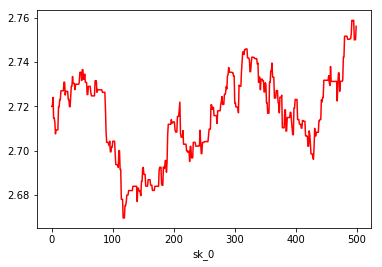

[2.72       2.72       2.71720729 ... 2.74487616 2.74487616 2.73473752]


In [25]:
output_factor_la_sk.shape
plt.plot(np.arange(0,sim),output_factor_la_sk[:,0], 'r-', alpha=1)
plt.xlabel('sk_0')
plt.show()
print(output_factor_la_sk[:,12])

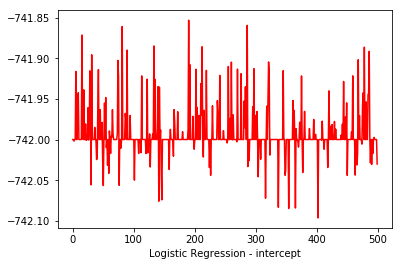

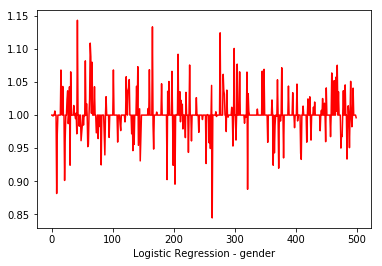

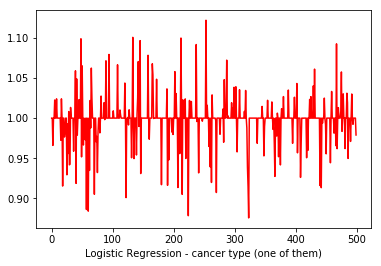

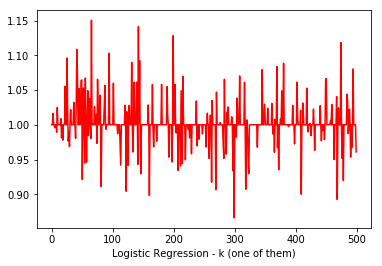

In [16]:
plt.plot(np.arange(0,len(output_logistic[:,0])),output_logistic[:,0], 'r-', alpha=1)
plt.xlabel('Logistic Regression - intercept')
plt.show()
#plt.savefig('Data\\lr_intercept.png')

plt.plot(np.arange(0,len(output_logistic[:,1])),output_logistic[:,1], 'r-', alpha=1)
plt.xlabel('Logistic Regression - gender')
plt.show()

#plt.savefig('Data\\lr_gender.png')

plt.plot(np.arange(0,len(output_logistic[:,10])),output_logistic[:,10], 'r-', alpha=1)
plt.xlabel('Logistic Regression - cancer type (one of them)')
plt.show()

#plt.savefig('Data\\lr_cancertype.png')

plt.plot(np.arange(0,len(output_logistic[:,30])),output_logistic[:,30], 'r-', alpha=1)
plt.xlabel('Logistic Regression - k (one of them)')
plt.show()

#plt.savefig('Data\\lr_k.png')

